# CIFAR10

In [1]:
import keras
from keras.datasets import cifar10

In [2]:
# 데이터 불러오기
(x_train,y_train),(x_test,y_test)=cifar10.load_data()

170498071/170498071 [==============================] - 14s 0us/step


In [3]:
# 데이터 타입 float으로 바꾸기
x_train=x_train.astype('float32')
x_test=x_test.astype('float32')

In [4]:
# train-valid 분할
x_train,x_valid=x_train[5000:],x_train[:5000]
y_train,y_valid=y_train[5000:],y_train[:5000]

In [5]:
print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)

(45000, 32, 32, 3) (45000, 1)
(5000, 32, 32, 3) (5000, 1)
(10000, 32, 32, 3) (10000, 1)


In [6]:
# 데이터 정규화 (Normalization)
import numpy as np

mean=x_train.mean()
std=x_train.std()

print(mean,std)

120.735214 64.12227


In [7]:
x_train=(x_train-mean)/(std+1e-7)
x_valid=(x_valid-mean)/(std+1e-7)
x_test=(x_test-mean)/(std+1e-7)

In [8]:
# 원핫인코딩
from keras.utils import to_categorical

num_classes=len(np.unique(y_train)) # 10가지로 분류해야함

y_train=to_categorical(y_train,num_classes)
y_valid=to_categorical(y_valid,num_classes)
y_test=to_categorical(y_test,num_classes)

In [9]:
y_train.shape

(45000, 10)

# 교재정리 
__4.6. 학습 및 최적화__  
+ `Learning Rate`
    + Learning Rage Decay : 고정된 학습률대신 학습 진행중에 lr을 감쇠시키는 방법
        + step decay
        + exponential decay
    + Adaptive Learning : 알아서 잘 LR 조정해줌
        + Adam, Adagrad 등  
+ `Batch Size`
    + BGD : 한번에 다 -> 메모리 많이 씀
    + SGD : 한개씩 -> 속도 느림, 노이즈 많음
    + MB-GD : 몇개씩 분할해서 
        + 보통 32 -> 64 -> 128 ...

        <br/>  

__4.7. 최적화 알고리즘__  
+ `Momentum`  
    경사가 기존 이동 방향과 같으면 이동 폭 증가, 다르면 감소 시킴  
$W=W-\alpha \cdot 경사 + 속도$  
-> 가중치 이동 방향의 진동을 감소시킴  
+ `Adam`
    모멘텀이랑 비슷한데 더 빠름, 마찰력 뭐시기..  

    ```
        keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epslilon=1e-8)
    ```

+ Epoch & Early Stopping  
    + Epoch : 전체 train data가 모델에 한번 노출된 횟수 (한바퀴 다 돌았냐~)
    + Early Stopping : 에포크 다 안돌았는데 진전이 없으면 모델 학습 조기 종료시킴

        ```
            EarlyStopping(monitor='val_loss',min_delta=0,patience=20)
        ```   

__4.8. 과적합 방지__  
+ `L2 규제` : 역전파 계산 과정에서 가중치 수정시 추가되는 양의 항이 있음  
    $Error_{new}=Error_{old}+\frac{\lambda}{2m}\times Σ\lVert{w}\rVert^2$  
    $W_{new}=W_{old}=\alpha \cdot \frac{\partial Error}{\partial W_{x}}$  
    가중치 업데이트 함수 공식에서 $Error$함수 값이 커짐  
    -> $W_{new}$ 작아짐 __가중치 감쇠__  
    -> 해당 뉴런의 영향력이 작아짐. 

    ```
        from keras import regularizers
        model.add(Dense(filters,kernel_size,kernel_regularizer=l2(lambda),activation)
    ```  

+ `Dropout` : 뉴런 일부를 꺼놓는 방법  
    보통 0.3~0.5
    + L2 규제와 달리 일부 뉴런을 완전이 비활성화 시킴

+ `Data Augmentation` : 데이터 강화, train data를 이렇게 저렇게 변형시켜서 양을 늘림  
    모델이 특징 학습 중 대상의 원래 모습에 대한 의존도를 낮춤 

    ```
        from keras.preprocessing.image import ImageDataGenerator

        datagen=ImageDataGenerator(horizontal_flip=True, # 상하반전
                                   vertical_flip=True) # 좌우반전
        datagen.fit(x_train)
    ```



__4.9. 배치 정규화__  
뉴런에서 출력된 특징 값들을 정규화한 후에 다음층 뉴런으로 입력시키는 방법  
-> NN의 학습속도 향상에도 기여함  
+ __covariance shift__ 공변량 시프트 문제  
    1. Layer3의 input은 Layer2의 output
    2. Layer2의 output은 Layer1 파라미터가 바뀌면 변화하는 값
    3. Layer3 입장에서는 Layer2의 output이 자꾸 변함 
    -> 이때, 배치 정규화를 통해 출력값 분포의 변화를 억제시킬 수 있음!
    + Dropout층 다음에 BN Layer 넣지 않는다
        + 이유 : BN에서 평균,표준편차 계산할 때 일부 뉴런 출력값만 사용할 순 없음

## Data Augmentation 데이터 강화

In [10]:
from keras.preprocessing.image import ImageDataGenerator

datagen=ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False
)

datagen.fit(x_train)

## 모델 구축하기  
+ 6CONV + 1FC
+ 짝수번째 CONV 뒤에 POOL
+ 모든 CONV 뒤에 BN
+ 모든 POOL 뒤에 DO
+ L2 규제 적용

In [14]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout
from keras.regularizers import l2

In [12]:
input_shape=x_train.shape[1:]

In [20]:
model=Sequential()

model.add(Conv2D(filters=32,kernel_size=3,padding='same',
                 kernel_regularizer=l2(1e-4),activation='relu',input_shape=input_shape))
                 # L2규제
model.add(BatchNormalization()) # Batch-Normalization (covariance shift 완화)

model.add(Conv2D(filters=32,kernel_size=3,padding='same',
                 kernel_regularizer=l2(1e-4),activation='relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2)) # Dropout

model.add(Conv2D(filters=64,kernel_size=3,padding='same',
                 kernel_regularizer=l2(1e-4),activation='relu'))
model.add(BatchNormalization())

model.add(Conv2D(filters=64,kernel_size=3,padding='same',
                 kernel_regularizer=l2(1e-4),activation='relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))

model.add(Conv2D(filters=128,kernel_size=3,padding='same',
                 kernel_regularizer=l2(1e-4),activation='relu'))
model.add(BatchNormalization())

model.add(Conv2D(filters=128,kernel_size=3,padding='same',
                 kernel_regularizer=l2(1e-4),activation='relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(10,activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_6 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_7 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                      

## 모델 컴파일  
+ 손실함수, optimizer, metrics 설정


In [21]:
from keras.optimizers import Adam 

optimizer=Adam(learning_rate=0.0001, decay=1e-6) 

model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])

+ 가중치 기록, 조기 종료

In [22]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpointer=ModelCheckpoint('/content/drive/MyDrive/AI부트캠프/SeSAC_DL/23_0109_1.CIFAR10.20epochs.hdf5',
                             verbose=1,save_best_only=True)
earlystopping=EarlyStopping(monitor='val_loss',patience=5)

In [23]:
batch_size=64
epochs=20

hist=model.fit(datagen.flow(x_train,y_train,batch_size=batch_size),
               epochs=epochs,
               validation_data=(x_valid,y_valid),
               callbacks=[checkpointer,earlystopping],
               verbose=2)

Epoch 1/20

Epoch 1: val_loss improved from inf to 1.56486, saving model to /content/drive/MyDrive/AI부트캠프/SeSAC_DL/23_0109_1.CIFAR10.20epochs.hdf5
704/704 - 34s - loss: 2.5226 - accuracy: 0.2977 - val_loss: 1.5649 - val_accuracy: 0.4698 - 34s/epoch - 49ms/step
Epoch 2/20

Epoch 2: val_loss improved from 1.56486 to 1.45751, saving model to /content/drive/MyDrive/AI부트캠프/SeSAC_DL/23_0109_1.CIFAR10.20epochs.hdf5
704/704 - 26s - loss: 1.8803 - accuracy: 0.3944 - val_loss: 1.4575 - val_accuracy: 0.4988 - 26s/epoch - 37ms/step
Epoch 3/20

Epoch 3: val_loss improved from 1.45751 to 1.32657, saving model to /content/drive/MyDrive/AI부트캠프/SeSAC_DL/23_0109_1.CIFAR10.20epochs.hdf5
704/704 - 25s - loss: 1.6712 - accuracy: 0.4480 - val_loss: 1.3266 - val_accuracy: 0.5382 - 25s/epoch - 36ms/step
Epoch 4/20

Epoch 4: val_loss did not improve from 1.32657
704/704 - 25s - loss: 1.5257 - accuracy: 0.4873 - val_loss: 1.3298 - val_accuracy: 0.5474 - 25s/epoch - 36ms/step
Epoch 5/20

Epoch 5: 

## 결과 확인하기

In [24]:
import matplotlib.pyplot as plt

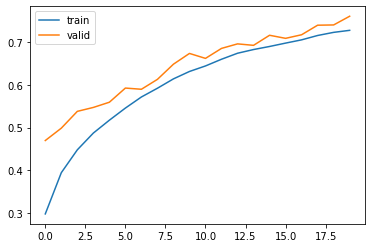

In [25]:
plt.plot(hist.history['accuracy'],label='train')
plt.plot(hist.history['val_accuracy'],label='valid')
plt.legend()
plt.show()

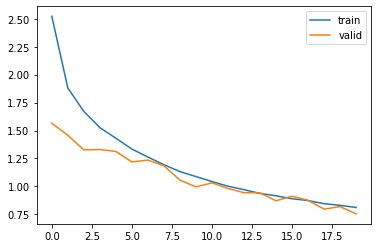

In [26]:
plt.plot(hist.history['loss'],label='train')
plt.plot(hist.history['val_loss'],label='valid')
plt.legend()
plt.show()